# Libraries

In [1]:
import numpy as np

# ELIOCENTRIC TRAJECTORY AND VELOCITIES

## Distance of planets from Sun

In [2]:
r_s = 9.555  #AU
r_j = 5.203  #AU

## Semi-Major Axis of transfer

In [3]:
a_t = (r_s + r_j)/2
print('Semi-major axis of the Hohmann transfer in AU:', a_t)

Semi-major axis of the Hohmann transfer in AU: 7.379


## Eccentricity

In [4]:
epsilont = (r_s-r_j)/(r_s+r_j) #Eccentricity of transfer orbit
print('Eccentricity of the transfer orbit:', epsilont)

Eccentricity of the transfer orbit: 0.2948909066269142


##Time steps setting


In [5]:
dt = 35
N_steps_ellipse = 3640

# qt of steps for first simulation
N_sim_first=50

def compute_steps_full_simulation(
    dt = 35, # step size (in days)
    N_steps_ellipse = 3640,# qt of steps for ellipse
    N_sim_first=50, # qt of steps for first simulation, before transfer
):
  time_orbits_sim = (dt * N_sim_first)
  num_steps = N_steps_ellipse+time_orbits_sim # adding steps for first simulation

  return time_orbits_sim, num_steps

# time_orbits_sim, num_steps = compute_steps_full_simulation(
#     dt = 14, # step size (in days)
#     N_steps_ellipse = 3640,# qt of steps for ellipse
#     N_sim_first=50, # qt of steps for first simulation, before transfer

# )
# time_orbits_sim, num_steps, N_steps_ellipse

## Find the Elliptic and the Planets Orbits

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_positions(
    N_steps_ellipse,
    dt,
    thetas_interval = [np.pi, 2*np.pi],
    pthetas_interval = [0, 2*np.pi],

):
  # Define the range of theta values
  step_size = N_steps_ellipse//dt    # <-------- IF ONE WANTS TO HAVE MORE VELOCITY DATA, INCREASE HERE

  thetas = np.linspace(thetas_interval[0],
                       thetas_interval[1],
                       step_size)  # <-------- From here one controls from where we start to where we go

  pthetas = np.linspace(pthetas_interval[0],
                        pthetas_interval[1],
                        step_size)

  # Define the polar equation for an ellipse
  r_function = lambda theta: (a_t * (1 - epsilont**2)) / (1 + epsilont * np.cos(theta))

  # Compute the r values for each theta
  r_values = list(map(r_function, thetas))

  x_values = r_values * np.cos(thetas)
  y_values = r_values * np.sin(thetas)

  # Compute circular orbit of Saturn
  x_valuesS = r_s * np.cos(pthetas)
  y_valuesS = r_s * np.sin(pthetas)

  # Compute circular orbit of Saturn
  x_valuesJ = r_j * np.cos(pthetas)
  y_valuesJ = r_j * np.sin(pthetas)

  return r_values, \
    x_values, y_values, \
    x_valuesS, y_valuesS, \
    x_valuesJ, y_valuesJ

# r_values, x_values, y_values, x_valuesS, y_valuesS, x_valuesJ, y_valuesJ = compute_positions(
#     N_steps_ellipse,
#     dt,
# )

## Velocities of circular orbits

We compute the velocities of the circular orbits of the planets around the Sun

In [7]:
import math as m
#From rescaling we get
sun_mass = 334448; # Sun mass in Earth mass units
G =  9.001123e-10; # AU^3/(day^2 * Earth mass)
mu = G*sun_mass


v_s = m.sqrt(mu / r_s) #AU/DAY
v_j = m.sqrt(mu / r_j) #AU/DAY

print('Velocity of circular orbit of Saturn around Sun in AU/DAY:', v_s)
print('Velocity of circular orbit of Jupiter around Sun in AU/DAY:', v_j)

Velocity of circular orbit of Saturn around Sun in AU/DAY: 0.005613029233430266
Velocity of circular orbit of Jupiter around Sun in AU/DAY: 0.007606515189301976


# Spacecraft Velocities

## Spacecraft velocity at perihelion and Aphelion

In [8]:
arg_s = 1/(r_s) - 1/(2*a_t)

arg_j = 1/(r_j) - 1/(2*a_t)

v_ts = m.sqrt(2*mu*arg_s)   #AU/DAY
v_tj = m.sqrt(2*mu*arg_j)   #AU/DAY

print('Velocity of the spacecraft at aphelion of the elliptic transfer in AU/DAY:', v_ts)
print('Velocity of the spacecraft at perihelion of the elliptic transfer in AU/DAY:', v_tj)

Velocity of the spacecraft at aphelion of the elliptic transfer in AU/DAY: 0.004713304108057347
Velocity of the spacecraft at perihelion of the elliptic transfer in AU/DAY: 0.008655702623964628


## Energy of the Transfer

The constant total energy of the spacecraft in the elliptic orbit around the Sun is

In [9]:
E_t = -mu / (2*a_t)

##Final total velocity change

Finally, the total Δv
 is found by the sum of the Δv
 at each end of the transfer orbit

In [10]:
Delta_v = abs(v_ts - v_s) + abs(v_tj - v_j)

print('Overall velocity change:',Delta_v)

Overall velocity change: 0.0019489125600355706


## Time required for completing the transfer

In [11]:
t_sj = (m.pi * a_t**(3/2)) / m.sqrt(mu)  #DAYS
t_sj_years = t_sj/365 #YEARS

print('The transfer from Saturn to Jupiter will take in DAYS:', t_sj)
print('The transfer from Saturn to Jupiter will take in YEARS:', t_sj_years)

The transfer from Saturn to Jupiter will take in DAYS: 3629.388747597421
The transfer from Saturn to Jupiter will take in YEARS: 9.9435308153354


# Time Dependency

## Integration with solver for $\theta(t)$ Ellipse

In [12]:
from scipy.integrate import solve_ivp

# # Constants
a = a_t   # Semi-major axis
e = epsilont

# Differential equation for theta as a function of time
def dtheta_dt(t, theta):
     return (np.sqrt(mu)*(1+e*np.cos(theta))**2)/(a**(3/2)*(1-e**2)**(3/2)) #differential equation

def integrate_ellipse_angles(
    N_steps_ellipse,
    dt,
    theta_0 = np.pi, # Initial conditions
    # t_span = (0, N_steps_ellipse),  # Time range for the solution
    # t_eval = np.linspace(0, N_steps_ellipse, N_steps_ellipse//dt),  # Time points where we evaluate the solution

):
  t_span = (0, N_steps_ellipse)  # Time range for the solution
  t_eval = np.linspace(0, N_steps_ellipse, N_steps_ellipse//dt)

  print('t_span len: {}'.format(len(t_span)))
  print('t_eval len: {}'.format(len(t_eval)))

  # Solve the ODE
  solution = solve_ivp(dtheta_dt, t_span, [theta_0], t_eval=t_eval, method='RK45')

  # Extract the solution
  t = solution.t
  theta_int = solution.y[0]

  return t, theta_int

def plot_solution(t, theta_int):
  plt.plot(t, theta_int)
  plt.xlabel('Time')
  plt.ylabel('Theta')
  plt.title('Theta as a function of time')
  plt.grid(True)
  plt.show()


# t, theta_int = integrate_ellipse_angles(N_steps_ellipse, dt)

##Find the Ellipse vector $[\theta,r]$

In [13]:
def compute_elipse(theta_int, r_values):
  return np.column_stack((theta_int, r_values))

# ellipse1 = compute_elipse(theta_int, r_values)

# # Print the first 3 rows
# print('First 3 rows of the ellipse vector:')
# print(ellipse1[:3])

# # Print the last 3 rows
# print('Last 3 rows of the ellipse vector:')
# print(ellipse1[-3:])

##Transform the Ellipse in Cartesian coordinates

In [14]:
def transform_ellipse_to_cartesian_coord(ellipse1,
                                         verbose=True):
  # Transform the ellipse into Cartesian coordinates
  ellipse_cart1 = np.zeros((ellipse1.shape[0], 2))  # Initialize matrix to store Cartesian coordinates

  for i in range(ellipse1.shape[0]):
      theta1 = ellipse1[i, 0]
      r1 = ellipse1[i, 1]
      x_ellipse1 = ellipse1[i, 1] * m.cos(ellipse1[i, 0])
      y_ellipse1 = ellipse1[i, 1] * m.sin(ellipse1[i, 0])

      if abs(x_ellipse1) <1e-10:
        x_ellipse1=0
      if abs(y_ellipse1) <1e-10:
        y_ellipse1=0

      ellipse_cart1[i, 0] = x_ellipse1
      ellipse_cart1[i, 1] = y_ellipse1

  if verbose:
    # Print the first 3 rows
    print('First 3 rows of the ellipse vector:')
    print(ellipse_cart1[:3])

    # Print the last 3 rows
    print('Last 3 rows of the ellipse vector:')
    print(ellipse_cart1[-3:])

  return ellipse_cart1

# ellipse_cart1 = transform_ellipse_to_cartesian_coord(ellipse1,
#                                          verbose=True)

In [15]:
# ellipse_cart1.shape

##Compute the Vis-Viva, Radial and Tangential velocity along the Ellipse

In [16]:
def compute_v_theta_and_vis_viva(ellipse1,
                                 verbose=True):
  velocities = []
  tang_velocities = []
  radial_velocities = []

  # Compute v_theta and vis_viva for each row in ellipse
  for i in range(ellipse1.shape[0]):
      theta = ellipse1[i, 0]
      r = ellipse1[i, 1]

      # Calculate vis_viva using the vis-viva equation
      arg_t = 1 / r - 1 / (2 * a_t)
      vis_viva = m.sqrt(2 * mu * arg_t)
      v_theta = m.sqrt((mu * (1 + epsilont * m.cos(theta))) / r)

      if vis_viva >= v_theta:
        v_rad = m.sqrt(((vis_viva)**2) - ((v_theta)**2))
      else:
        v_rad = 0

      if abs(v_rad) < 1e-7:
        v_r=0

      velocities.append(vis_viva)
      tang_velocities.append(v_theta)
      radial_velocities.append(v_rad)

  if verbose:
    # Print the first three and last three velocities
    print('First three velocities:', velocities[:3])
    print('Last three velocities:', velocities[-3:])

    print('First three tang_velocities:', tang_velocities[:3])
    print('Last three tang_velocities:', tang_velocities[-3:])

    print('First three radial_velocities:', radial_velocities[:3])
    print('Last three radial_velocities:', radial_velocities[-3:])

  return vis_viva, velocities, tang_velocities, radial_velocities

# vis_viva, velocities, tang_velocities, radial_velocities = compute_v_theta_and_vis_viva(ellipse1)

##Compute Cartesian velocity vector

In [17]:
def compute_v_cart(ellipse1,
                   tang_velocities,
                   radial_velocities,
                   verbose=True):

    velocity_polar = np.zeros((ellipse1.shape[0], 2))  # 2 columns: v_theta, v_r

    for i in range(ellipse1.shape[0]):

        # Store the results
        velocity_polar[i,0] = tang_velocities[i]
        velocity_polar[i,1] = radial_velocities[i]


    velocity_cart = np.zeros((ellipse1.shape[0], 2))  # 2 columns: v_theta, v_r

    for i in range(ellipse1.shape[0]):

        v_x_theta = -velocity_polar[i,0] * m.sin(ellipse1[i,0]) #CAREFUL, the conversion need to take into account that the angular vector is perpendicular to the radius, we need to be careful!
        v_y_theta = velocity_polar[i,0] * m.cos(ellipse1[i,0])
        v_x_r = velocity_polar[i,1] * m.cos(ellipse1[i,0])
        v_y_r = velocity_polar[i,1] * m.sin(ellipse1[i,0])

        v_x = v_x_r + v_x_theta
        v_y = v_y_r + v_y_theta

        if abs(v_x) < 1e-10:
          v_x = 0

        if abs(v_y) < 1e-10:
          v_y = 0


        # Store the results
        velocity_cart[i,0] =  v_x
        velocity_cart[i,1] =  v_y

    return velocity_cart

# velocity_cart = compute_v_cart(ellipse1,
#                    tang_velocities,
#                    radial_velocities,)

# #print(velocity_cart)

In [18]:
# plt.figure(figsize=(10,3))
# plt.title('Evolution of velocities')
# plt.plot(range(len(velocities)),
#          velocities,
#          label='computed velocities')
# plt.plot([0, len(velocities)-1],
#          [velocities[0], velocities[-1]],
#          linestyle='dashed',
#          label=r'constant acceleration $a =(v_f-v_i) / \Delta t$')
# plt.xlabel('time step')
# plt.ylabel('velocity magnitude')
# plt.legend(bbox_to_anchor=(1.01, 0.9))
# plt.show()

In [19]:
# (v_j-v_s)/(len(velocities)*dt)

In [20]:
# len(velocities)

# PHASE ANGLE AND AND TRANSFER PHASING

## Period and $w_j$ $w_s$ for Saturn and Jupiter

In [21]:
T_s = ((2* m.pi) / (m.sqrt(mu))) * r_s**(3/2)
T_j = ((2* m.pi) / (m.sqrt(mu))) * r_j**(3/2)

print('Period of Saturn in Days: ', T_s)
print('Period of Jupiter in Days: ', T_j)

w_s = (2*m.pi)/(T_s)
w_j = (2*m.pi)/(T_j)

print('w_s of Saturn in Days: ', w_s)
print('w_j of Jupiter in Days: ', w_j)

Period of Saturn in Days:  10695.799560874815
Period of Jupiter in Days:  4297.81737624524
w_s of Saturn in Days:  0.0005874441897886203
w_j of Jupiter in Days:  0.0014619479510478526


## Initial $\gamma_1$

In [22]:
Gamma_1 = m.pi - (w_j * t_sj) % (2 * m.pi)
print('Phase angle at Departure:', Gamma_1)

Phase angle at Departure: -2.1643847895163884


##Synodic Period $T_{syn}$

In [23]:
T_syn = T_s * T_j / (T_s - T_j)
T_syn_years = T_syn/365
print('Synodic Period in DAYS:',T_syn)
print('Synodic Period in YEARS:',T_syn_years)

Synodic Period in DAYS: 7184.857956622371
Synodic Period in YEARS: 19.684542346910604


##Initial angle of the planets

In [24]:
theta_0_s = np.pi
theta_0_j = theta_0_s + Gamma_1

print(theta_0_s, theta_0_j)

3.141592653589793 0.9772078640734048


#SPACECRAFT ROTATION AROUND SATURN

In [25]:
saturn_mass=95.18072
mu_s=G*saturn_mass

r_sp = 0.1 #AU
theta_0_sp = 0

T_sp = ((2* m.pi) / (m.sqrt(mu_s))) * r_sp**(3/2)
w_sp = (2* m.pi) / T_sp

#SIMULATIONS WITH KALMAN FILTER

## formatting the time counter

In [26]:
from datetime import timedelta

def force_double_digits(x):
  if len(str(x))==1:
    return f'0{x}'
  return x

def format_time_passed(frame, num_steps, dt):
    days_passed = frame * dt

    # Compute years, months, weeks, and days
    years, remainder = divmod(days_passed, 365)
    months, remainder = divmod(remainder, 30)
    weeks, days = divmod(remainder, 7)

    parts = [
        f"{force_double_digits(years)} years",
        f"{force_double_digits(months)} months",
        f"{force_double_digits(weeks)} weeks",
        f"{force_double_digits(days)} days"
    ]
    return " and ".join(parts)

# testing with some values:
num_steps = 3640
dt = 7
frames = [1, 4, 7, 10, 14, 30, 365]
for frame in frames:
    print(f"Frame {force_double_digits(frame)}: {format_time_passed(frame, num_steps, dt)}")

Frame 01: 00 years and 00 months and 01 weeks and 00 days
Frame 04: 00 years and 00 months and 04 weeks and 00 days
Frame 07: 00 years and 01 months and 02 weeks and 05 days
Frame 10: 00 years and 02 months and 01 weeks and 03 days
Frame 14: 00 years and 03 months and 01 weeks and 01 days
Frame 30: 00 years and 07 months and 00 weeks and 00 days
Frame 365: 07 years and 00 months and 00 weeks and 00 days


## Necessary computations for KF

In [27]:
def compute_simulation_values(
    dt = 14, # step size (in days)
    N_steps_ellipse = 3640,# qt of steps for ellipse
    N_sim_first=50, # qt of steps for first simulation, before transfer
):

  time_orbits_sim, num_steps = compute_steps_full_simulation(
      dt = dt, # step size (in days)
      N_steps_ellipse = N_steps_ellipse,# qt of steps for ellipse
      N_sim_first=N_sim_first, # qt of steps for first simulation, before transfer
  )
  r_values, x_values, y_values, x_valuesS, y_valuesS, x_valuesJ, y_valuesJ = compute_positions(
      N_steps_ellipse,
      dt,
  )

  t, theta_int = integrate_ellipse_angles(
      N_steps_ellipse=N_steps_ellipse,
      dt=dt,
  )

  ellipse1 = compute_elipse(theta_int, r_values)
  ellipse_cart1 = transform_ellipse_to_cartesian_coord(ellipse1,
                                         verbose=True)

  vis_viva, velocities, tang_velocities, radial_velocities = compute_v_theta_and_vis_viva(ellipse1)

  return ellipse_cart1, vis_viva, velocities


## make animation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import offsetbox
import cv2
import matplotlib.image as mpl_image

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d


def compute_angle_update(theta_0, w, t):
    return theta_0 + w * t

# Function to compute orbits
def compute_orbits_both_simulations(r_j, r_s, w_s, w_j, dt, num_steps,
                   theta_0_s_first,
                   theta_0_j_first):
    #=====================================================
    # compute saturn's orbit
    #=====================================================
    thetas_s = np.array([
        compute_angle_update(theta_0=theta_0_s_first, w=w_s, t=t)
        for t in range(1, num_steps+1, dt)
    ])

    x_s = r_s * np.cos(thetas_s)
    y_s = r_s * np.sin(thetas_s)

    #=====================================================
    # compute jupiter's orbit
    #=====================================================
    thetas_j = np.array([
        compute_angle_update(theta_0=theta_0_j_first, w=w_j, t=t)
        for t in range(1, num_steps+1, dt)
    ])

    x_j = r_j * np.cos(thetas_j)
    y_j = r_j * np.sin(thetas_j)

    return x_s, y_s, \
           x_j, y_j

### comparing the Kalman-Filter velocities and Hohmann Transfer pre-computed velocities

t_span len: 2
t_eval len: 104
First 3 rows of the ellipse vector:
[[-9.555       0.        ]
 [-9.55169007 -0.16653348]
 [-9.54176869 -0.33286454]]
Last 3 rows of the ellipse vector:
[[ 5.18363506 -0.47337666]
 [ 5.20069074 -0.17251272]
 [ 5.20133031  0.13180301]]
First three velocities: [0.004713304108057347, 0.00471460420563709, 0.0047185011408394616]
Last three velocities: [0.008652870651606614, 0.00865499455307324, 0.008655702623964628]
First three tang_velocities: [0.0047133041080573475, 0.004713912282813001, 0.004715736366486083]
Last three tang_velocities: [0.008649784861468088, 0.008654702413163462, 0.008655386329791825]
First three radial_velocities: [0, 8.077007958181694e-05, 0.00016150398726947745]
Last three radial_velocities: [0.00023106787693782298, 7.11115553899676e-05, 7.399592259672898e-05]
ellipse_cart1 len: (104, 2)
r_values len: 104
x_values len: 104
t_span len: 2
t_eval len: 104
theta_int len: 104
ellipse1 len: (104, 2)
First three velocities: [0.004713304108057347

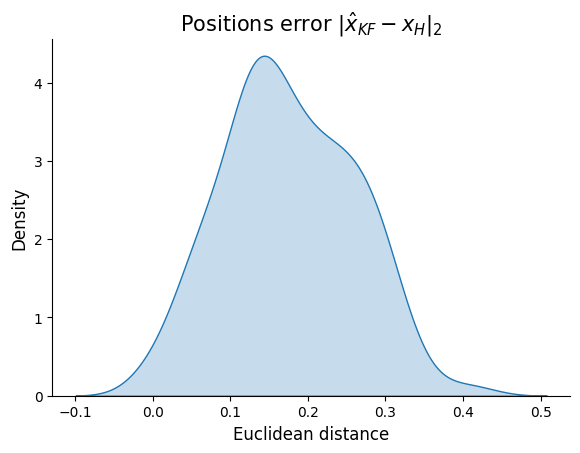

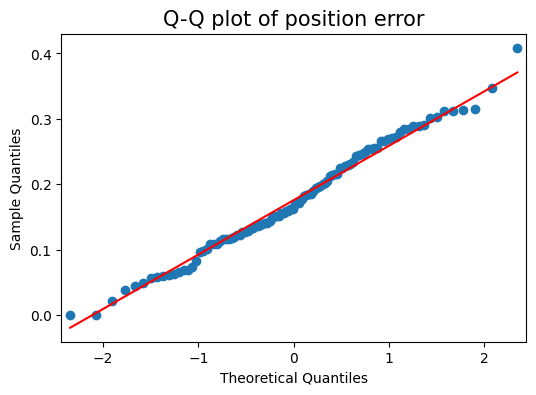

Statistics=1.642, p=0.440
significance value: 0.040, p_value: 0.440
(p>alpha) Sample looks Gaussian (fail to reject H0)


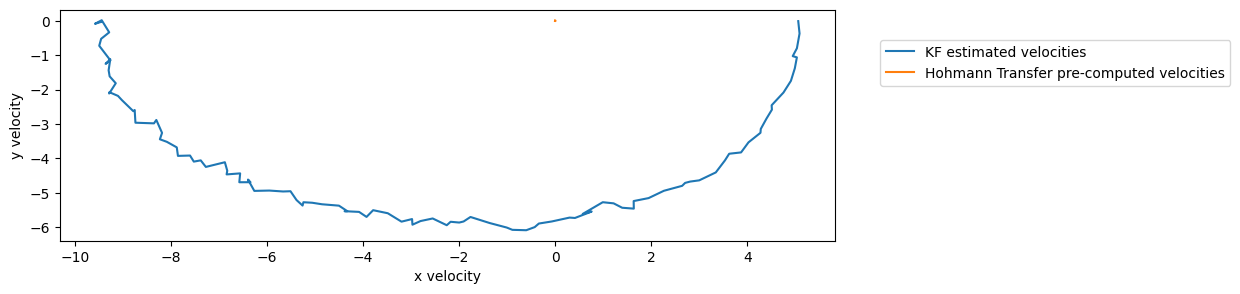

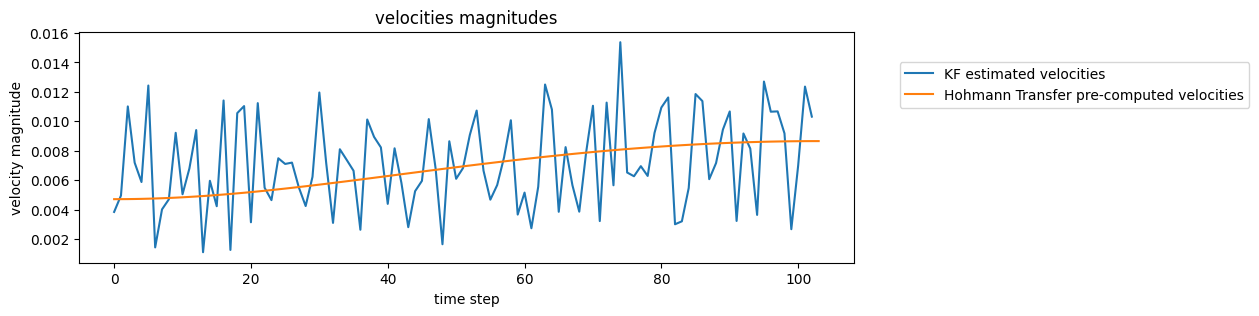

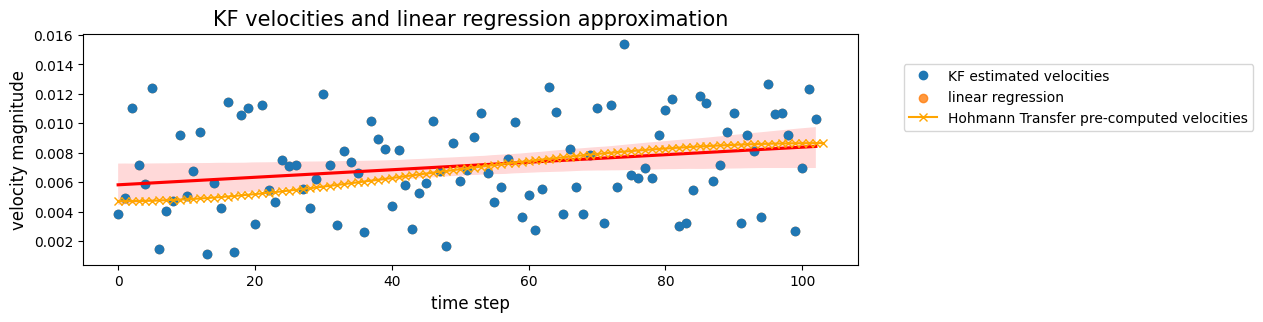

---- velocity euclidean distance: [0.00475553 0.00863964 0.00696147 0.00483843 0.00154271 0.00856636
 0.00354142 0.00345829 0.00901888 0.00446492 0.00058883 0.00369168
 0.00541493 0.00602776 0.00536913 0.00266584 0.00783634 0.00607695
 0.00544867 0.01174892 0.00808515 0.00630248 0.00160232 0.00496511
 0.00556415 0.00167555 0.00883015 0.00177454 0.00747548 0.00239968
 0.01425948 0.00147942 0.00294344 0.00975772 0.00213793 0.00811748
 0.00854168 0.00422979 0.00982979 0.00853307 0.00687889 0.00224023
 0.00234194 0.00904511 0.00654043 0.00607833 0.00918151 0.00289875
 0.00758516 0.00800545 0.00241655 0.01172544 0.00635618 0.00460746
 0.00850303 0.00400549 0.00888244 0.00837315 0.00370167 0.00878657
 0.00476572 0.00673173 0.00896689 0.00566784 0.00426158 0.00388446
 0.00438875 0.0068412  0.00806548 0.00530569 0.00728165 0.00494189
 0.00828856 0.01302136 0.01229508 0.00162365 0.00391414 0.00124376
 0.0105859  0.00237893 0.00551706 0.00401276 0.00649274 0.00519832
 0.0030415  0.00410427 0.006

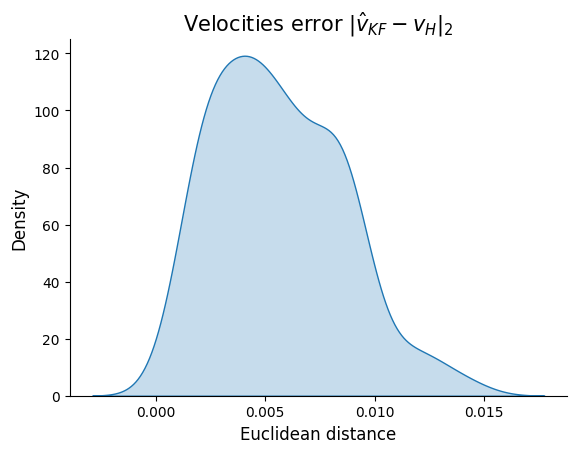

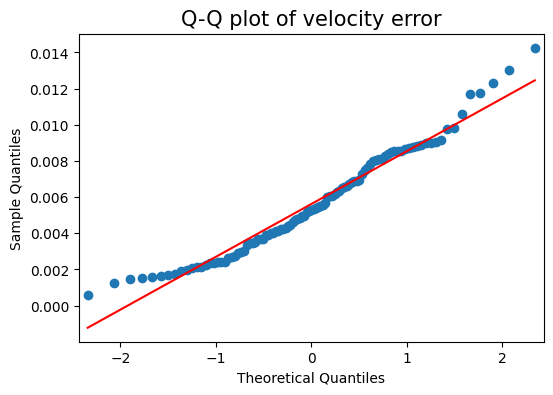

Statistics=5.053, p=0.080
significance value: 0.040, p_value: 0.080
(p>alpha) Sample looks Gaussian (fail to reject H0)


In [29]:
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest
import pandas as pd
# from sklearn.metrics import root_mean_squared_error


def run_normality_test(data, alpha=0.04):

  # normality test
  stat, p = normaltest(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  print('significance value: {:.3f}, p_value: {:.3f}'.format(
      alpha, p
  ))
  if p > alpha:
    print('(p>alpha) Sample looks Gaussian (fail to reject H0)')
  else:
    print('(p<=alpha) Sample does not look Gaussian (reject H0)')

def compute_euclidean_distance(predicted, true):
  # Initialize lists to store the results
  distances = []

  # Compute the Euclidean distance for each pair manually
  for i in range(len(predicted)):
      x_diff = predicted[i][0] - true[i][0]
      y_diff = predicted[i][1] - true[i][1]
      distance = np.sqrt(x_diff**2 + y_diff**2)
      distances.append(distance)

  # Convert the list to a numpy array for further calculations
  distances = np.array(distances)
  return distances

def estimate_trajectory_with_kalman_filter(
    x_obs, y_obs,
    x_hat,
    A, H, Q, R, P,
    velocity_cart,
    use_precomputed_velocities=True
    # assume_nonconstant_acceleration=False
):
  """"
  https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial
  """
  # Kalman Filter estimates
  x_estimates = []
  for k in range(len(x_obs)):
      # update state vector with pre-computed velocities
      if use_precomputed_velocities:
        x_hat[2] = velocity_cart[k, 0]
        x_hat[3] = velocity_cart[k, 1]

      print('(k: {}) (v_x, v_y)=({:.3f}, {:.3f}), velocity magnitude: {}'.format(
          k,
          velocity_cart[k, 0],
          velocity_cart[k, 1],
          np.sqrt(velocity_cart[k, 0]**2 +\
                  velocity_cart[k, 1]**2)
      ))
      # if assume_nonconstant_acceleration:
      #   x_hat[4] = a_x  # Updating x acceleration
      #   x_hat[5] = a_y  # Updating y acceleration

      # Prediction
      x_hat = A @ x_hat
      P = A @ P @ A.T + Q

      # Update
      z = np.array([x_obs[k], y_obs[k]])
      y = z - H @ x_hat
      S = H @ P @ H.T + R
      K = P @ H.T @ np.linalg.inv(S)
      x_hat = x_hat + K @ y
      P = (np.eye(P.shape[0]) - K @ H) @ P

      x_estimates.append(x_hat[:2])
  x_estimates = np.array(x_estimates)

  return x_estimates

def compute_kalmanfilter_velocites_an_positions(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days


    sigma = 0.2, # variance of observed measurements for Kalman-Filter

    # Constants for Kalman Filter
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]),
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]]),
    Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    P = np.eye(4) * 500,

    assume_constant_velocity=True,
    initial_acceleration=[1, 1],

    use_precomputed_velocities = True,
):
  """
  Assume the following values are given and constant:
    r_j, r_s,
    w_s, w_j,
    theta_0_s, theta_0_j,
  -----------------------------------------------------------------
  Parameters
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days
    sigma = 0.2, # variance of observed measurements for Kalman-Filter
  Returns
    None, animation is saved
  -----------------------------------------------------------------
  """
  ##============================================================================
  ##      Compute necessary values
  ##============================================================================
  time_orbits_sim, num_steps = compute_steps_full_simulation(
      dt,
      N_steps_ellipse,
      N_sim_first
  )
  # time_orbits_sim = (dt * N_sim_first)
  # num_steps = N_steps_ellipse+time_orbits_sim # adding steps for first simulation

  ellipse_cart1, vis_viva, velocities = compute_simulation_values(
      dt = dt, # step size (in days)
      N_steps_ellipse = N_steps_ellipse,# qt of steps for ellipse
      N_sim_first=N_sim_first, # qt of steps for first simulation, before transfer
  )
  print('ellipse_cart1 len: {}'.format(ellipse_cart1.shape))

  r_values, x_values, y_values, x_valuesS, y_valuesS, x_valuesJ, y_valuesJ = compute_positions(
      N_steps_ellipse,
      dt,
  )
  print('r_values len: {}'.format(len(r_values)))
  print('x_values len: {}'.format(len(x_values)))

  # RK45 integration (with error)
  t, theta_int = integrate_ellipse_angles(N_steps_ellipse=N_steps_ellipse,
                                          dt=dt)
  print('theta_int len: {}'.format(len(theta_int)))

  ellipse1 = compute_elipse(theta_int, r_values)
  print('ellipse1 len: {}'.format(ellipse1.shape))

  vis_viva, velocities, tang_velocities, radial_velocities = compute_v_theta_and_vis_viva(ellipse1)

  velocity_cart = compute_v_cart(ellipse1,
                   tang_velocities,
                   radial_velocities,)
  print('velocity_cart len: {}'.format(velocity_cart.shape))

  # matrix of state velocities
  # precomputed_velocities = np.zeros(shape=(vel_x.shape[0], 2))
  # precomputed_velocities[:, 0] = vel_x
  # precomputed_velocities[:, 1] = vel_y
  # precomputed_velocities = velocity_cart

  ##============================================================================
  ##      Start animation
  ##============================================================================

  x_s, y_s, x_j, y_j = compute_orbits_both_simulations(
                                      r_j, r_s,
                                      w_s, w_j,
                                      dt=dt,
                                      num_steps=num_steps,
                                      theta_0_s_first=theta_0_s - (w_s*time_orbits_sim),
                                      theta_0_j_first=theta_0_j- (w_j*time_orbits_sim),
                                      )
  print('x_s len: {}'.format(len(x_s)))
  print('x_j len: {}'.format(len(x_j)))

  # Compute Hohmann transfer trajectory
  x_hohmann, y_hohmann = ellipse_cart1[:, 0], ellipse_cart1[:, 1]

  print('x_hohmann len: {}'.format(len(x_hohmann)))

  # Initial state estimate (starting at Saturn)
  if assume_constant_velocity:
    # x_hat = np.array([x_hohmann[-1], y_hohmann[-1], 0, 0])
    x_hat = np.array([x_hohmann[0], y_hohmann[0],
                      velocity_cart[0, 0],
                      velocity_cart[0, 1]])
  else:
    # Initial state estimate (x_hat)
    initial_position = np.array([x_hohmann[0], y_hohmann[0]])
    initial_velocity = np.array([velocity_cart[0, 0],
                                 velocity_cart[0, 1]])
    x_hat = np.concatenate([initial_position, initial_velocity, initial_acceleration])


  # Observed (noisy) Hohmann transfer trajectory
  np.random.seed(42)
  x_obs = x_hohmann + np.random.normal(0, sigma, size=x_hohmann.shape)
  y_obs = y_hohmann + np.random.normal(0, sigma, size=y_hohmann.shape)


  # estimate each step with Kalman-Filter
  x_estimates = estimate_trajectory_with_kalman_filter(
      x_obs, y_obs,
      x_hat,
      A, H, Q, R, P,
      velocity_cart,
      use_precomputed_velocities
  )
  print('x_estimates shape: {}'.format(x_estimates.shape))

  kf_x_values = x_estimates[:, 0]
  kf_y_values = x_estimates[:, 1]

  ############# positions

  # error = np.sqrt((kf_x_values - x_obs)**2 + (kf_y_values - y_obs)**2)
  # print('|x_obs - x_kf|_2 error: ', error)

  x_mag_ht = np.sqrt(x_obs**2 + y_obs**2)
  x_mag_kf = np.sqrt(kf_x_values**2 + kf_y_values**2)

  d_pos = compute_euclidean_distance(predicted = x_estimates,
                             true = np.array([[x,y] for x,y in zip(x_obs, y_obs)])
                             )
  print(f'---- position euclidean distance: {d_pos}')
  g = sns.displot(x = d_pos,
              kind='kde', fill=True)
  g.fig.set_figwidth(6)
  g.fig.set_figheight(4)
  plt.title(r'Positions error $|\hat{x}_{KF} - x_{H}|_2$',
            fontsize=15)
  plt.xlabel('Euclidean distance', fontsize=12)
  plt.ylabel('Density', fontsize=12)
  plt.show()

  ## QQ plot and normality test
  g = qqplot(d_pos, line='s')
  # g.set_figwidth(11.27)
  # g.set_figheight(3.7)
  g.set_figwidth(6)
  g.set_figheight(4)
  plt.title('Q-Q plot of position error',
            fontsize=15)
  plt.show()

  run_normality_test(d_pos)


  # print('|x_obs - x_kf|_2 error: ', np.linalg.norm(x_mag_ht-x_mag_kf,
  #                                                  ord=2))

  # # Compute the differences in coordinates
  # diff_x = x_obs - kf_x_values
  # diff_y = y_obs - kf_y_values

  # Compute the Euclidean distances
  # euclidean_distances = np.sqrt(diff_x**2 + diff_y**2)

  # Calculate the 2-norm of the Euclidean distances
  # norm_2_error = np.linalg.norm(euclidean_distances,
  #                               ord=2,
  #                               # axis=1
  #                               )

  # print('|x_obs - x_kf|_2 error: ', norm_2_error)

  # N_obs = len(x_obs)
  # mse = sum((x_obs - kf_x_values)**2 + (y_obs + kf_y_values)**2)/N_obs
  # mae = sum(abs(x_obs - kf_x_values) + abs(y_obs - kf_y_values))/N_obs

  # errors_dict = {
  #     'MSE': mse,
  #     'RMSE': np.sqrt(mse),
  #     'MAE': mae
  # }
  # print(errors_dict)


  # residuals_pos = abs(x_mag_ht-x_mag_ht)
  # print(f'residuals_pos: {residuals_pos}')
  # g = sns.displot(x = residuals_pos,
  #             kind='kde', fill=True)
  # g.fig.set_figwidth(11.27)
  # g.fig.set_figheight(3.7)
  # plt.title(r'Positions Residuals $r = |\hat{x}_{KF} - x_{H}|$',
  #           fontsize=15)
  # plt.xlabel('Residual', fontsize=12)
  # plt.ylabel('Density', fontsize=12)
  # plt.show()

  ############# velocities

  # v_{kf} = dx_{kf}/dt
  kf_vel_x = (np.diff(kf_x_values))/dt
  kf_vel_y = (np.diff(kf_y_values))/dt

  kf_velocities = np.sqrt(kf_vel_x**2 + kf_vel_y**2)
  ht_velocities = np.sqrt(velocity_cart[:, 0]**2 + velocity_cart[:, 1]**2)

  # (x,y) components
  plt.figure(figsize=(10, 3))
  plt.plot(kf_x_values, kf_y_values,
           label='KF estimated velocities')
  plt.plot(velocity_cart[:, 0], velocity_cart[:, 1],
           label='Hohmann Transfer pre-computed velocities')
  plt.xlabel('x velocity')
  plt.ylabel('y velocity')
  plt.legend(bbox_to_anchor=(1.05, 0.9))
  plt.show()

  # velocities magnitudes
  plt.figure(figsize=(10, 3))
  plt.title('velocities magnitudes')
  plt.plot(kf_velocities,
           label='KF estimated velocities')
  plt.plot(ht_velocities,
           label='Hohmann Transfer pre-computed velocities')
  plt.xlabel('time step')
  plt.ylabel('velocity magnitude')
  plt.legend(bbox_to_anchor=(1.05, 0.9))
  plt.show()

  kf_results = pd.DataFrame({
      'timestep': list(range(len(kf_velocities))),
      'v_kf': kf_velocities
  })

  # regression of KF velocities
  plt.plot(kf_velocities,
           label='KF estimated velocities',
           linestyle='None', marker='o')
  g = sns.regplot(data=kf_results, x="timestep", y="v_kf",
               robust=True, # downweight outliers
                  # order=3
                  line_kws=dict(color="red"),
                  label='linear regression'
              )
  g.figure.set_size_inches(10, 3)
  plt.plot(ht_velocities, marker='x',
           color='orange',
           label='Hohmann Transfer pre-computed velocities')
  plt.title('KF velocities and linear regression approximation',
            fontsize=15)
  plt.legend(bbox_to_anchor=(1.05, 0.9))
  plt.xlabel('time step', fontsize=12)
  plt.ylabel('velocity magnitude', fontsize=12)
  plt.show()

  # print('kf_velocities head: {}'.format(kf_velocities[:5]))
  # print('kf_velocities tail: {}'.format(kf_velocities[-5:]))

  # error_estimate = np.linalg.norm(np.array(kf_velocities) - np.array(ht_velocities[1:]),
  #                                 # axis=1,
  #                                 ord=2
  #                                 )
  # print('error_estimate: ', error_estimate)

  d_vel = compute_euclidean_distance(
                             predicted = np.array([[x,y] for x,y in zip(kf_vel_x, kf_vel_y)]),
                             true = np.array(velocity_cart)
                             )
  print(f'---- velocity euclidean distance: {d_vel}')
  g = sns.displot(x = d_vel,
              kind='kde', fill=True)
  # g.fig.set_figwidth(11.27)
  # g.fig.set_figheight(3.7)
  g.fig.set_figwidth(6)
  g.fig.set_figheight(4)
  plt.title(r'Velocities error $|\hat{v}_{KF} - v_{H}|_2$',
            fontsize=15)
  plt.xlabel('Euclidean distance', fontsize=12)
  plt.ylabel('Density', fontsize=12)
  plt.show()

  # residuals = abs(kf_velocities-ht_velocities[1:])
  # g = sns.displot(x = residuals,
  #             kind='kde', fill=True)
  # g.fig.set_figwidth(11.27)
  # g.fig.set_figheight(3.7)
  # plt.title(r'Residuals $r = |\hat{v}_{KF} - v_{H}|$',
  #           fontsize=15)
  # plt.xlabel('Residual', fontsize=12)
  # plt.ylabel('Density', fontsize=12)
  # plt.show()

  g = qqplot(d_vel, line='s')
  # g.set_figwidth(11.27)
  # g.set_figheight(3.7)
  g.set_figwidth(6)
  g.set_figheight(4)
  plt.title('Q-Q plot of velocity error',
            fontsize=15)
  plt.show()

  run_normality_test(d_vel)


  return x_estimates, d_pos


x_estimates, position_error = compute_kalmanfilter_velocites_an_positions(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days


    sigma = 0.2, # variance of observed measurements for Kalman-Filter

    # Constants for Kalman Filter
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]),
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]]),
    Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    P = np.eye(4) * 500,

    assume_constant_velocity=True,
    initial_acceleration=[1, 1],

    use_precomputed_velocities = True,
)

In [30]:
def run_normality_test(data, alpha=0.04):

  # normality test
  stat, p = normaltest(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  print('significance value: {:.3f}, p_value: {:.3f}'.format(
      alpha, p
  ))
  if p > alpha:
    print('(p>alpha) Sample looks Gaussian (fail to reject H0)')
  else:
    print('(p<=alpha) Sample does not look Gaussian (reject H0)')

run_normality_test(position_error, alpha=0.05)

Statistics=1.642, p=0.440
significance value: 0.050, p_value: 0.440
(p>alpha) Sample looks Gaussian (fail to reject H0)


In [31]:
# kf_x_values = x_estimates[:, 0]
# kf_y_values = x_estimates[:, 1]

# # v_{kf} = dx_{kf}/dt
# kf_vel_x = (np.diff(kf_x_values))/dt
# kf_vel_y = (np.diff(kf_y_values))/dt

# kf_velocities = np.sqrt(kf_vel_x**2 + kf_vel_y**2)

## Animations

In [32]:
def image(ax,arr,xy, zoom=0.05):
  """ Place an image (arr) as annotation at position xy """
  im = offsetbox.OffsetImage(arr, zoom=zoom)
  im.image.axes = ax
  ab = offsetbox.AnnotationBbox(im, xy, frameon=False)
  ax.add_artist(ab)

def proj(X, ax1, ax2):
  """ From a 3D point in axes ax1,
      calculate position in 2D in ax2 """
  x,y,z = X
  x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
  return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))

def make_animation(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days


    sigma = 0.2, # variance of observed measurements for Kalman-Filter

    # Constants for Kalman Filter
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]),
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]]),
    Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    P = np.eye(4) * 500,

    assume_constant_velocity=True,
    initial_acceleration=[1, 1],

    use_precomputed_velocities = True,
    use_kalman_filter = False,

    output_filename="trajectory_kalman_animation_with_correct_velocities.gif",
    save_animation=True
):
  """
  Assume the following values are given and constant:
    r_j, r_s,
    w_s, w_j,
    theta_0_s, theta_0_j,
  -----------------------------------------------------------------
  Parameters
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days
    sigma = 0.2, # variance of observed measurements for Kalman-Filter
  Returns
    None, animation is saved
  -----------------------------------------------------------------
  """
  ##============================================================================
  ##      Compute necessary values
  ##============================================================================
  time_orbits_sim, num_steps = compute_steps_full_simulation(
      dt,
      N_steps_ellipse,
      N_sim_first
  )
  # time_orbits_sim = (dt * N_sim_first)
  # num_steps = N_steps_ellipse+time_orbits_sim # adding steps for first simulation

  ellipse_cart1, vis_viva, velocities = compute_simulation_values(
      dt = dt, # step size (in days)
      N_steps_ellipse = N_steps_ellipse,# qt of steps for ellipse
      N_sim_first=N_sim_first, # qt of steps for first simulation, before transfer
  )
  print('ellipse_cart1 len: {}'.format(ellipse_cart1.shape))

  r_values, x_values, y_values, x_valuesS, y_valuesS, x_valuesJ, y_valuesJ = compute_positions(
      N_steps_ellipse,
      dt,
  )
  print('r_values len: {}'.format(len(r_values)))
  print('x_values len: {}'.format(len(x_values)))

  # RK45 integration (with error)
  t, theta_int = integrate_ellipse_angles(N_steps_ellipse=N_steps_ellipse,
                                          dt=dt)
  print('theta_int len: {}'.format(len(theta_int)))

  ellipse1 = compute_elipse(theta_int, r_values)
  print('ellipse1 len: {}'.format(ellipse1.shape))

  vis_viva, velocities, tang_velocities, radial_velocities = compute_v_theta_and_vis_viva(ellipse1)

  velocity_cart = compute_v_cart(ellipse1,
                   tang_velocities,
                   radial_velocities,)
  print('velocity_cart len: {}'.format(velocity_cart.shape))

  # matrix of state velocities
  # precomputed_velocities = np.zeros(shape=(vel_x.shape[0], 2))
  # precomputed_velocities[:, 0] = vel_x
  # precomputed_velocities[:, 1] = vel_y
  # precomputed_velocities = velocity_cart

  ##============================================================================
  ##      Start animation
  ##============================================================================

  x_s, y_s, x_j, y_j = compute_orbits_both_simulations(
                                      r_j, r_s,
                                      w_s, w_j,
                                      dt=dt,
                                      num_steps=num_steps,
                                      theta_0_s_first=theta_0_s - (w_s*time_orbits_sim),
                                      theta_0_j_first=theta_0_j- (w_j*time_orbits_sim),
                                      )
  print('x_s len: {}'.format(len(x_s)))
  print('x_j len: {}'.format(len(x_j)))

  # Compute Hohmann transfer trajectory
  x_hohmann, y_hohmann = ellipse_cart1[:, 0], ellipse_cart1[:, 1]

  print('x_hohmann len: {}'.format(len(x_hohmann)))

  # Initial state estimate (starting at Saturn)
  if assume_constant_velocity:
    # x_hat = np.array([x_hohmann[-1], y_hohmann[-1], 0, 0])
    x_hat = np.array([x_hohmann[0], y_hohmann[0],
                      velocity_cart[0, 0],
                      velocity_cart[0, 1]])
  else:
    # Initial state estimate (x_hat)
    initial_position = np.array([x_hohmann[0], y_hohmann[0]])
    initial_velocity = np.array([velocity_cart[0, 0],
                                 velocity_cart[0, 1]])
    x_hat = np.concatenate([initial_position, initial_velocity, initial_acceleration])


  # Observed (noisy) Hohmann transfer trajectory
  np.random.seed(42)
  x_obs = x_hohmann + np.random.normal(0, sigma, size=x_hohmann.shape)
  y_obs = y_hohmann + np.random.normal(0, sigma, size=y_hohmann.shape)

  # estimate each step with Kalman-Filter
  if use_kalman_filter:
    x_estimates = estimate_trajectory_with_kalman_filter(
        x_obs, y_obs,
        x_hat,
        A, H, Q, R, P,
        velocity_cart,
        use_precomputed_velocities
    )

  # Initialize plot
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  ax2 = fig.add_subplot(111,frame_on=False)
  ax2.axis("off")
  ax2.axis([0,1,0,1])

  # Initialize data lists for animation
  saturn_x, saturn_y = [], []
  jupiter_x, jupiter_y = [], []
  hohmann_x, hohmann_y = [], []
  kf_x, kf_y = [], []

  # Function to initialize the plot
  def init():
      ax.plot(x_s, y_s, np.zeros_like(x_s), 'brown', linestyle='dotted', label="Saturn's Orbit")
      ax.plot(x_j, y_j, np.zeros_like(x_j), 'orange', linestyle='dotted', label="Jupiter's Orbit")
      ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun')

      # Annotate Saturn and Jupiter
      ax.text(x_s[0], y_s[0], 0, "Saturn", color='brown', fontsize=12, ha='right')
      ax.text(x_j[0], y_j[0], 0, "Jupiter", color='orange', fontsize=12, ha='right')

      ax.plot(x_hohmann, y_hohmann, np.zeros_like(x_hohmann), 'b', label='Hohmann Transfer')


      # Add small spheres for Saturn and Jupiter
      ax.scatter([x_s[0]], [y_s[0]], [0], color='brown', s=50)
      ax.scatter([x_j[0]], [y_j[0]], [0], color='orange', s=50)

      ax.legend()
      return ax,

  # Function to update the plot for each frame
  def update(frame):
      if frame >= num_steps // dt:
          print(f'passing frame {frame} ({frame}/{(num_steps // dt)})({round(100 * frame / (num_steps // dt), 3)}%)')
          pass
      else:
          if frame < N_sim_first:

            ax.clear()

            print(f'(first simulation) using frame {frame} ({frame}/{(num_steps // dt)})({round(100 * frame / (num_steps // dt), 3)}%)')

            # run just orbits, with spacecraft glued to saturn

            ax.plot(x_s, y_s, np.zeros_like(x_s), color='brown', linestyle='dashed', label="Saturn's Orbit")
            ax.plot(x_j, y_j, np.zeros_like(x_j), color='orange', linestyle='dashed', label="Jupiter's Orbit")

            # text annotation
            ax.text(x_s[frame], y_s[frame], 0, "Saturn", color='brown', fontsize=12, ha='right')
            ax.text(x_j[frame], y_j[frame], 0, "Jupiter", color='orange', fontsize=12, ha='right')

            ax.plot(x_s[:frame], y_s[:frame], np.zeros_like(x_s[:frame]),
                    'brown', label="Saturn's trajectory")
            ax.plot(x_j[:frame], y_j[:frame], np.zeros_like(x_j[:frame]),
                    'orange', label="Jupiter's trajectory")

            ax.plot(x_hohmann, y_hohmann, np.zeros_like(x_hohmann), color='b', linestyle='dashed', label='Hohmann Transfer')

            ax2.clear()
            # sun img
            sun_xyz = [0, 0, 0]
            x_sun_img, y_sun_img = proj(sun_xyz, ax, ax2)
            image(ax2, plt.imread('sun (1).png'),[x_sun_img, y_sun_img], zoom=0.06)

            # saturn img
            s_xyz = [x_s[frame], y_s[frame], 0]
            x_s_img, y_s_img = proj(s_xyz, ax, ax2)
            image(ax2, plt.imread('saturn.png'),[x_s_img, y_s_img], zoom=0.025)
            image(ax2, plt.imread('spaceship (1).png'),[x_s_img, y_s_img], zoom=0.025)

            # jupiter img
            j_xyz = [x_j[frame], y_j[frame], 0]
            x_j_img, y_j_img = proj(j_xyz, ax, ax2)
            image(ax2, plt.imread('jupiter.png'),[x_j_img, y_j_img], zoom=0.025)

            ax.legend()

            # Add time counter
            ax.text2D(0.05, 0.95, f"Time: {format_time_passed(frame, num_steps, dt)}", transform=ax.transAxes, fontsize=12, color='black')
            ax.text2D(0.05, 0.1,
                      "velocity of spacecraft: {:.4f} [AU/day]".format(
                          v_s),
                      transform=ax.transAxes, fontsize=12, color='black',
                      bbox=dict(facecolor='white'))

          elif frame >= N_sim_first:
            # adjusted frame for Kalman-Filter estimates (shift to 0)
            frame2 = frame - N_sim_first

            print(f'(elipse simulation) using frame {frame}, frame2: {frame2} ({frame}/{(num_steps // dt)})({round(100 * frame / (num_steps // dt), 3)}%)')
            ax.clear()

            ax.plot(x_s, y_s, np.zeros_like(x_s), color='brown', linestyle='dashed', label="Saturn's Orbit")
            ax.plot(x_j, y_j, np.zeros_like(x_j), color='orange', linestyle='dashed', label="Jupiter's Orbit")

            # Annotate Saturn and Jupiter
            ax.text(x_s[frame], y_s[frame], 0, "Saturn", color='brown', fontsize=12, ha='right')
            ax.text(x_j[frame], y_j[frame], 0, "Jupiter", color='orange', fontsize=12, ha='right')

            if use_kalman_filter:
              kf_x.append(x_estimates[frame2, 0])
              kf_y.append(x_estimates[frame2, 1])

            ax.plot(x_s[:frame], y_s[:frame], np.zeros_like(x_s[:frame]),
                    'brown', label="Saturn's trajectory")
            ax.plot(x_j[:frame], y_j[:frame], np.zeros_like(x_j[:frame]),
                    'orange', label="Jupiter's trajectory")

            ax.plot(x_hohmann, y_hohmann, np.zeros_like(x_hohmann), color='b', linestyle='dashed', label='Hohmann Transfer')

            if use_kalman_filter:
              ax.plot(kf_x, kf_y, np.zeros_like(kf_x), 'r', linestyle='None',
                    marker='.',
                    label='Kalman Filter Estimate')

            ax.legend()

            # Create a dummy axes to place annotations to
            ax2.clear()

            if use_kalman_filter:
              # compute img projection between ax2 and ax
              kf_xyz = [x_estimates[frame2, 0], x_estimates[frame2, 1], 0]
              x_kf_img, y_kf_img = proj(kf_xyz, ax, ax2)
              image(ax2, plt.imread('spaceship (1).png'),[x_kf_img, y_kf_img], zoom=0.025)
            else:
              h_xyz = [x_hohmann[frame2], y_hohmann[frame2], 0]
              x_h_img, y_h_img = proj(h_xyz, ax, ax2)
              image(ax2, plt.imread('spaceship (1).png'),[x_h_img, y_h_img], zoom=0.025)

            # sun img
            sun_xyz = [0, 0, 0]
            x_sun_img, y_sun_img = proj(sun_xyz, ax, ax2)
            image(ax2, plt.imread('sun (1).png'),[x_sun_img, y_sun_img], zoom=0.06)

            # saturn img
            s_xyz = [x_s[frame], y_s[frame], 0]
            x_s_img, y_s_img = proj(s_xyz, ax, ax2)
            image(ax2, plt.imread('saturn.png'),[x_s_img, y_s_img], zoom=0.025)

            # jupiter img
            j_xyz = [x_j[frame], y_j[frame], 0]
            x_j_img, y_j_img = proj(j_xyz, ax, ax2)
            image(ax2, plt.imread('jupiter.png'),[x_j_img, y_j_img], zoom=0.025)

            # Add time counter
            ax.text2D(0.05, 0.95, f"Time: {format_time_passed(frame, num_steps, dt)}", transform=ax.transAxes, fontsize=12, color='black')
            ax.text2D(0.05, 0.1,
                      "velocity of spacecraft: {:.4f} [AU/day]".format(velocities[frame2]),
                      transform=ax.transAxes, fontsize=12, color='black',
                      bbox=dict(facecolor='white',
                                # alpha=0.9
                                ))

          else:
            # run second simulation, with only orbits, and spacecraft glued to jupiter
            pass
      return ax,

  # Create the animation
  ani = FuncAnimation(fig, update, frames=num_steps // dt, init_func=init, blit=False)

  # Save the animation as GIF
  if save_animation:
    ani.save(output_filename,
            writer=PillowWriter(fps=30))
  plt.show()

## no KF

t_span len: 2
t_eval len: 260
First 3 rows of the ellipse vector:
[[-9.555       0.        ]
 [-9.55447643 -0.06623891]
 [-9.55290595 -0.13246507]]
Last 3 rows of the ellipse vector:
[[ 5.2021754  -0.11049212]
 [ 5.20307673  0.01042426]
 [ 5.20133031  0.13180301]]
First three velocities: [0.004713304108057347, 0.00471350975849295, 0.004714126625719344]
Last three velocities: [0.008655254686386898, 0.00865559063762434, 0.008655702623964628]
First three tang_velocities: [0.0047133041080573475, 0.004713400297055513, 0.00471368885301965]
Last three tang_velocities: [0.00865519037909667, 0.008655628141040391, 0.008655386329791825]
First three radial_velocities: [0, 3.2122937681176766e-05, 6.42436007268074e-05]
Last three radial_velocities: [3.3364469346622305e-05, 0, 7.399592259672898e-05]
ellipse_cart1 len: (260, 2)
r_values len: 260
x_values len: 260
t_span len: 2
t_eval len: 260
theta_int len: 260
ellipse1 len: (260, 2)
First three velocities: [0.004713304108057347, 0.00471350975849295, 

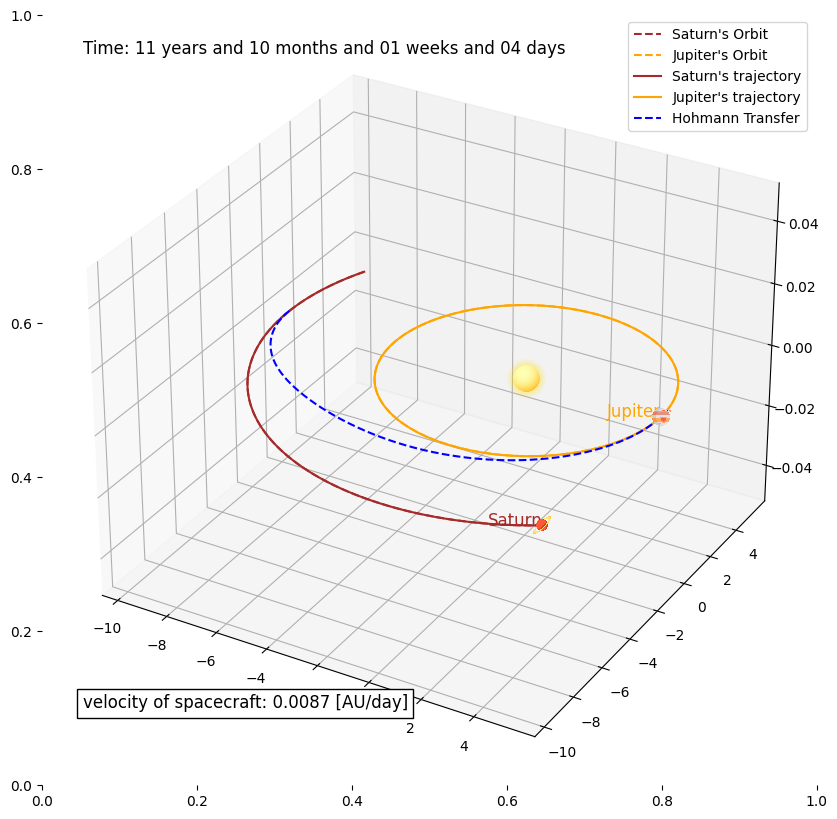

In [33]:
make_animation(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=14, # time step in days
    output_filename="simulation_no_kf_dt14.gif",

    use_kalman_filter = False

    # sigma = 0.2, # variance of observed measurements for Kalman-Filter
    # # Constants for Kalman Filter
    # A = np.array([[1, 0, dt, 0],
    #               [0, 1, 0, dt],
    #               [0, 0, 1, 0],
    #               [0, 0, 0, 1]]),
    # H = np.array([[1, 0, 0, 0],
    #               [0, 1, 0, 0]]),
    # Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    # R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    # P = np.eye(4) * 500,
)

t_span len: 2
t_eval len: 104
First 3 rows of the ellipse vector:
[[-9.555       0.        ]
 [-9.55169007 -0.16653348]
 [-9.54176869 -0.33286454]]
Last 3 rows of the ellipse vector:
[[ 5.18363506 -0.47337666]
 [ 5.20069074 -0.17251272]
 [ 5.20133031  0.13180301]]
First three velocities: [0.004713304108057347, 0.00471460420563709, 0.0047185011408394616]
Last three velocities: [0.008652870651606614, 0.00865499455307324, 0.008655702623964628]
First three tang_velocities: [0.0047133041080573475, 0.004713912282813001, 0.004715736366486083]
Last three tang_velocities: [0.008649784861468088, 0.008654702413163462, 0.008655386329791825]
First three radial_velocities: [0, 8.077007958181694e-05, 0.00016150398726947745]
Last three radial_velocities: [0.00023106787693782298, 7.11115553899676e-05, 7.399592259672898e-05]
ellipse_cart1 len: (104, 2)
r_values len: 104
x_values len: 104
t_span len: 2
t_eval len: 104
theta_int len: 104
ellipse1 len: (104, 2)
First three velocities: [0.004713304108057347

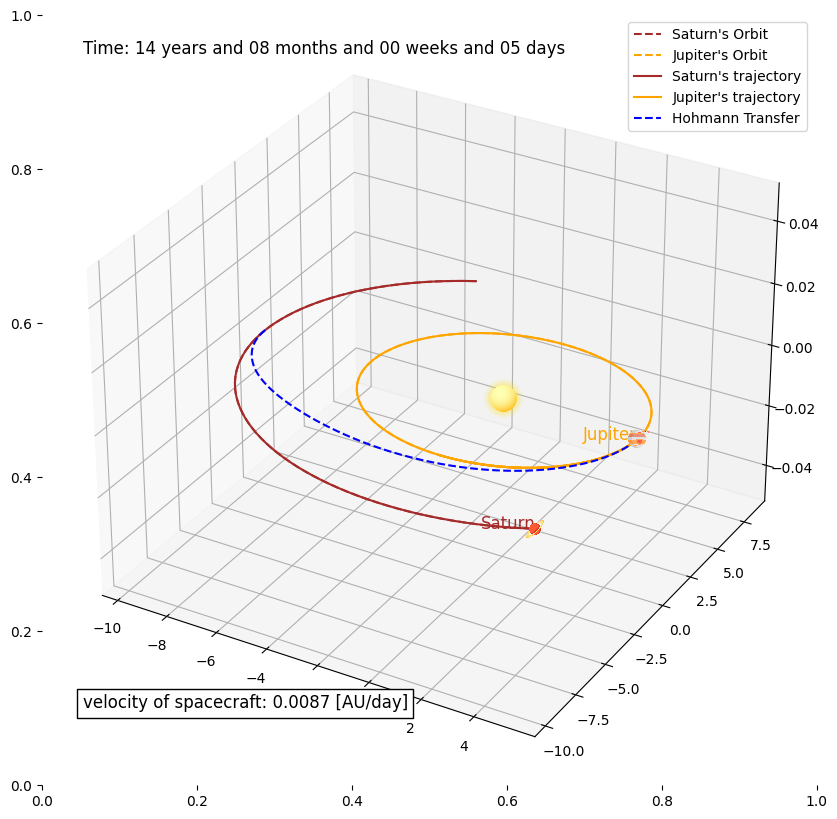

In [34]:
make_animation(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days
    output_filename="simulation_no_kf_dt35.gif",

    use_kalman_filter = False

    # sigma = 0.2, # variance of observed measurements for Kalman-Filter
    # # Constants for Kalman Filter
    # A = np.array([[1, 0, dt, 0],
    #               [0, 1, 0, dt],
    #               [0, 0, 1, 0],
    #               [0, 0, 0, 1]]),
    # H = np.array([[1, 0, 0, 0],
    #               [0, 1, 0, 0]]),
    # Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    # R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    # P = np.eye(4) * 500,
)

## with KF

In [35]:
# velocity_cart.shape

In [36]:
# np.sqrt(velocity_cart[:, 0]**2 + velocity_cart[:, 1]**2)[:104]

t_span len: 2
t_eval len: 104
First 3 rows of the ellipse vector:
[[-9.555       0.        ]
 [-9.55169007 -0.16653348]
 [-9.54176869 -0.33286454]]
Last 3 rows of the ellipse vector:
[[ 5.18363506 -0.47337666]
 [ 5.20069074 -0.17251272]
 [ 5.20133031  0.13180301]]
First three velocities: [0.004713304108057347, 0.00471460420563709, 0.0047185011408394616]
Last three velocities: [0.008652870651606614, 0.00865499455307324, 0.008655702623964628]
First three tang_velocities: [0.0047133041080573475, 0.004713912282813001, 0.004715736366486083]
Last three tang_velocities: [0.008649784861468088, 0.008654702413163462, 0.008655386329791825]
First three radial_velocities: [0, 8.077007958181694e-05, 0.00016150398726947745]
Last three radial_velocities: [0.00023106787693782298, 7.11115553899676e-05, 7.399592259672898e-05]
ellipse_cart1 len: (104, 2)
r_values len: 104
x_values len: 104
t_span len: 2
t_eval len: 104
theta_int len: 104
ellipse1 len: (104, 2)
First three velocities: [0.004713304108057347

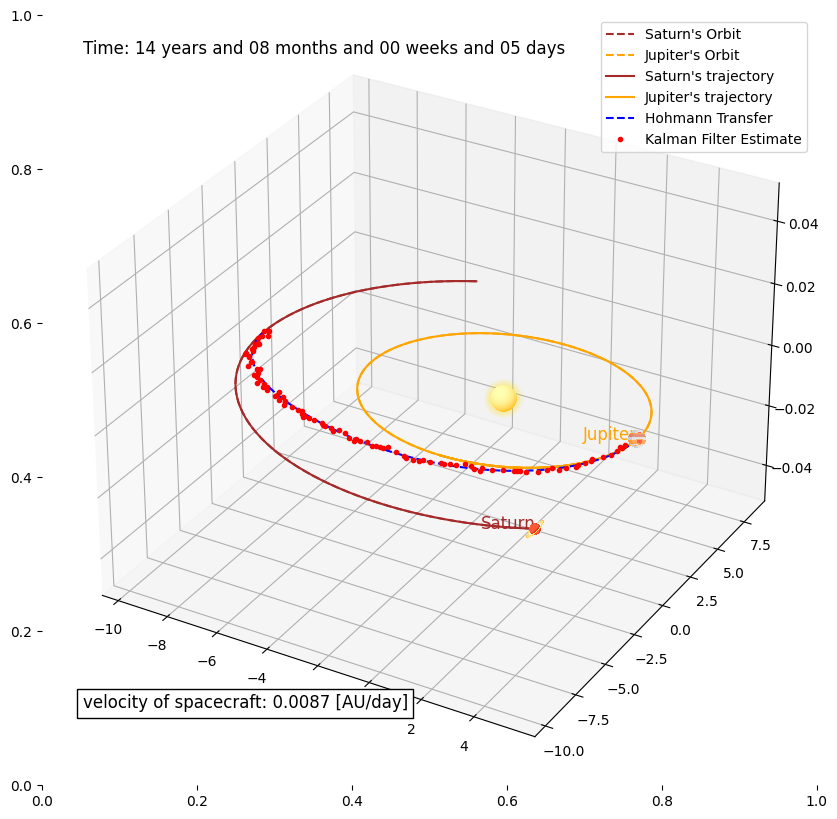

In [37]:
make_animation(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=35, # time step in days


    sigma = 0.2, # variance of observed measurements for Kalman-Filter

    # Constants for Kalman Filter
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]),

    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]]),

    Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    P = np.eye(4) * 500,

    assume_constant_velocity=True, # acceleration will be embedded in the precomputed velocities
    initial_acceleration=[1, 1],

    use_precomputed_velocities = True,
    use_kalman_filter = True,

    output_filename="sim_KF_precomp_velocities_dt35.gif",
    save_animation=True
)

t_span len: 2
t_eval len: 260
First 3 rows of the ellipse vector:
[[-9.555       0.        ]
 [-9.55447643 -0.06623891]
 [-9.55290595 -0.13246507]]
Last 3 rows of the ellipse vector:
[[ 5.2021754  -0.11049212]
 [ 5.20307673  0.01042426]
 [ 5.20133031  0.13180301]]
First three velocities: [0.004713304108057347, 0.00471350975849295, 0.004714126625719344]
Last three velocities: [0.008655254686386898, 0.00865559063762434, 0.008655702623964628]
First three tang_velocities: [0.0047133041080573475, 0.004713400297055513, 0.00471368885301965]
Last three tang_velocities: [0.00865519037909667, 0.008655628141040391, 0.008655386329791825]
First three radial_velocities: [0, 3.2122937681176766e-05, 6.42436007268074e-05]
Last three radial_velocities: [3.3364469346622305e-05, 0, 7.399592259672898e-05]
ellipse_cart1 len: (260, 2)
r_values len: 260
x_values len: 260
t_span len: 2
t_eval len: 260
theta_int len: 260
ellipse1 len: (260, 2)
First three velocities: [0.004713304108057347, 0.00471350975849295, 

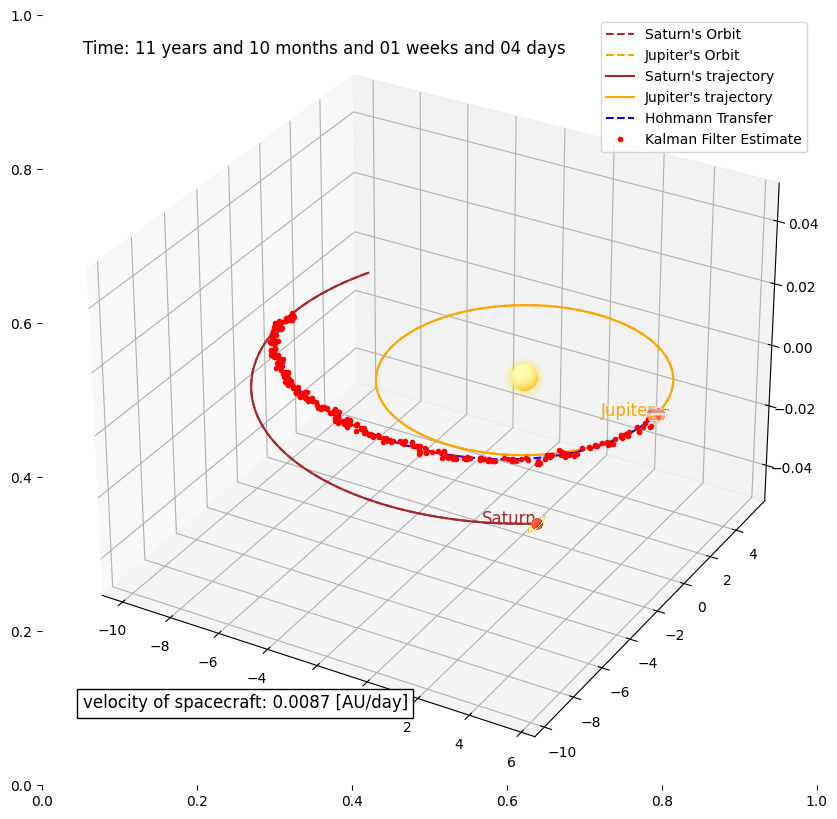

In [38]:
make_animation(
    N_steps_ellipse = 3640,
    N_sim_first=50, # qt of steps for first simulation
    dt=14, # time step in days

    sigma = 0.2, # variance of observed measurements for Kalman-Filter

    # Constants for Kalman Filter
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]),

    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]]),

    Q = np.eye(4) * 0.001, # process noise -> uncertanty of dynamics
    R = np.eye(2) * 0.5, # measurement noise -> uncertainty of measurements
    P = np.eye(4) * 500,

    assume_constant_velocity=True, # acceleration will be embedded in the precomputed velocities
    initial_acceleration=[1, 1],

    use_precomputed_velocities = True,
    use_kalman_filter = True,

    output_filename="sim_KF_precomp_velocities_dt14.gif",
    save_animation=True
)

In [39]:
import os
list(filter(lambda x: '.gif' in x, os.listdir()))

['simulation_no_kf_dt14.gif',
 'sim_KF_precomp_velocities_dt35.gif',
 'sim_KF_precomp_velocities_dt14.gif',
 'simulation_no_kf_dt35.gif']

## Kalman-Filter with adjusted parameters (nonconstant velocity)

In [40]:
# make_animation(
#     N_steps_ellipse = 3640,
#     N_sim_first=50, # qt of steps for first simulation
#     dt=35, # time step in days
#     sigma = 0.2, # variance of observed measurements for Kalman-Filter

#     # State transition matrix (A) for non-constant velocity
#     A = np.array([[1, 0, dt, 0, 0.5*dt**2, 0],
#                   [0, 1, 0, dt, 0, 0.5*dt**2],
#                   [0, 0, 1, 0, dt, 0],
#                   [0, 0, 0, 1, 0, dt],
#                   [0, 0, 0, 0, 1, 0],
#                   [0, 0, 0, 0, 0, 1]]),

#     # Observation matrix (H) remains the same
#     H = np.array([[1, 0, 0, 0, 0, 0],
#                   [0, 1, 0, 0, 0, 0]]),

#     # Process noise covariance (Q)
#     Q = np.eye(6) * 0.001,

#     # Measurement noise covariance (R)
#     R = np.eye(2) * 10,

#     # Initial covariance estimate (P)
#     P = np.eye(6) * 500,

#     assume_constant_velocity=False,
#     initial_acceleration=[1, 1],

#     output_filename="sim_KF_nonconstant_vel.gif"

# )